## EEG Signal Data for Quantum Machine Learning

Dataset Link: https://data.mendeley.com/v1/datasets/px9dpkssy8/draft?a=7140665d-a0f0-40b2-a9fd-a731d21b6222

### Note: Store the dataset folder containing all csv files for each subject in the same directory as this ipynb file.

In [3]:
import pandas as pd
import glob
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# # Prepare the combined csv and save it in the same directory

# # Load the CSV filepaths into a list
# filepaths = glob.glob('dataset/subject*.csv')
# dfs = []
# for filepath in filepaths:
#     df = pd.read_csv(filepath, sep=';')
#     dfs.append(df)

# # Combine the dataframes into a single dataframe
# df = pd.concat(dfs, axis=0, ignore_index=True)

# # Save the preprocessed data to a new CSV file
# df.to_csv('combined_dataset.csv', index=False)

In [4]:
# Read the combined dataset csv

df = pd.read_csv('combined_dataset.csv')
df

,F1,F2,F3,F4
0,410,316,749,520
1,513,297,739,509
2,511,297,738,491
3,492,273,733,558
4,472,285,710,555
...,...,...,...,...
45051,507,546,475,470
45052,512,498,489,500
45053,519,507,462,513
45054,498,528,450,533


In [11]:
df = df.transpose()
df

,0,1,2,3,4,5,6,7,8,9,...,45046,45047,45048,45049,45050,45051,45052,45053,45054,45055
F1,410,513,511,492,472,451,487,498,499,488,...,507,523,537,508,489,507,512,519,498,475
F2,316,297,297,273,285,321,325,330,304,294,...,522,500,532,541,564,546,498,507,528,553
F3,749,739,738,733,710,752,767,758,737,695,...,467,486,466,452,468,475,489,462,450,480
F4,520,509,491,558,555,527,520,494,545,554,...,470,493,495,522,503,470,500,513,533,519


In [26]:
# Segmenting dataframe into smaller dataframes

segment_size = 256

# segments is a list of sub-dataframes
segments = [df.iloc[:, i:i+segment_size].copy() for i in range(0, df.shape[1], segment_size)]

print(len(segments))

176


In [51]:
# sample segment

segments[0]

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
F1,410,513,511,492,472,451,487,498,499,488,...,444,445,499,475,457,463,448,505,511,488
F2,316,297,297,273,285,321,325,330,304,294,...,428,457,443,443,412,440,475,451,447,401
F3,749,739,738,733,710,752,767,758,737,695,...,378,412,413,387,385,398,450,444,447,449
F4,520,509,491,558,555,527,520,494,545,554,...,394,373,342,340,408,403,385,374,364,430


In [52]:
# sample segment

segments[1]

,256,257,258,259,260,261,262,263,264,265,...,502,503,504,505,506,507,508,509,510,511
F1,489,483,548,585,551,532,517,533,597,579,...,665,639,624,674,682,668,669,650,690,693
F2,401,462,442,446,412,412,462,437,425,413,...,443,467,526,511,496,476,480,533,529,518
F3,436,480,497,496,492,473,515,529,526,493,...,460,444,474,482,457,424,415,457,461,451
F4,432,413,414,382,430,440,417,418,380,428,...,709,705,700,684,630,681,690,674,670,643


In [46]:
feature_df = pd.DataFrame(columns=['mean_F1', 'mean_F2', 'mean_F3', 'mean_F4',
                                  'variance_F1', 'variance_F2', 'variance_F3', 'variance_F4',
                                  'skewness_F1', 'skewness_F2', 'skewness_F3', 'skewness_F4',
                                  'kurtosis_F1', 'kurtosis_F2', 'kurtosis_F3', 'kurtosis_F4'])

In [48]:
for segment in segments:
    feature_list = []
    feature_list.extend(segment.mean(axis='columns'))
    feature_list.extend(segment.var(axis='columns'))
    feature_list.extend(segment.skew(axis='columns'))
    feature_list.extend(segment.kurtosis(axis='columns'))
    
    feature_df.loc[len(feature_df)] = feature_list

In [49]:
feature_df

,mean_F1,mean_F2,mean_F3,mean_F4,variance_F1,variance_F2,variance_F3,variance_F4,skewness_F1,skewness_F2,skewness_F3,skewness_F4,kurtosis_F1,kurtosis_F2,kurtosis_F3,kurtosis_F4
0,502.636719,394.875000,686.765625,435.007812,6469.902803,2661.827451,18519.693873,14918.846998,-0.009519,-0.106849,-1.183153,-0.536615,-0.819542,-0.926274,0.027088,-1.101431
1,651.121094,358.535156,399.722656,512.179688,3211.910769,12107.386994,6937.134544,11297.034252,-0.454366,0.242054,0.037547,0.713799,0.020633,-1.022908,-1.109844,-0.394361
2,750.167969,442.421875,439.949219,603.238281,4044.124617,3027.021324,752.777803,6898.848882,0.976312,0.693362,0.052720,-0.003589,0.963696,-0.305457,-0.234582,-0.921374
3,651.917969,437.621094,437.640625,486.976562,31766.420695,5328.949985,1586.474265,3228.250429,0.379515,-0.545250,-0.333205,-0.112770,-1.223871,-0.822750,-0.380698,-0.297997
4,591.503906,584.187500,510.558594,456.261719,4818.149004,6060.905882,2397.008318,5827.237117,-0.941854,0.961542,0.139218,-0.959627,0.162641,0.442448,-0.838395,0.630231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,508.003906,512.781250,409.550781,513.761719,800.027436,485.363725,2688.617019,1577.750843,-0.269710,0.225623,0.950880,0.345208,-0.646520,0.042637,0.213161,-0.842939
172,458.648438,531.132812,409.984375,518.964844,408.926900,644.350919,2531.623284,435.602681,0.048565,0.073469,0.150773,-0.227519,-0.377774,-0.360350,-0.964552,-0.198792
173,482.101562,590.941406,631.734375,550.769531,447.566115,612.816161,2838.337010,997.385892,0.091636,-0.231447,-0.472744,0.205590,-0.233730,-0.412303,-0.681154,-0.233249
174,574.835938,438.093750,601.859375,477.996094,825.792586,4685.951961,1881.352696,1113.337240,-0.624771,0.015948,-0.281813,0.092839,0.788825,-1.287230,-1.126770,-0.881690


In [64]:
# Normalize the feature dataframe between -1 and 1

feature_df_normalized = (feature_df - feature_df.min()) / (feature_df.max() - feature_df.min())
feature_df_normalized = 2 * feature_df_normalized - 1

feature_df_normalized

,mean_F1,mean_F2,mean_F3,mean_F4,variance_F1,variance_F2,variance_F3,variance_F4,skewness_F1,skewness_F2,skewness_F3,skewness_F4,kurtosis_F1,kurtosis_F2,kurtosis_F3,kurtosis_F4
0,-0.089148,-0.031605,0.678384,-0.396995,-0.806393,-0.932673,-0.835320,-0.566513,0.383939,-0.189778,-0.537556,0.209427,-0.797924,-0.800899,-0.667168,-0.885856
1,0.304863,-0.134679,-0.134513,-0.157707,-0.910464,-0.652892,-0.940446,-0.674915,0.122165,-0.033337,0.041852,0.821297,-0.562752,-0.831654,-0.894123,-0.777288
2,0.567689,0.103257,-0.020593,0.124640,-0.883880,-0.921856,-0.996577,-0.806553,0.964060,0.169021,0.049054,0.470254,-0.298780,-0.603310,-0.719402,-0.858209
3,0.306977,0.089640,-0.027130,-0.235854,0.001659,-0.853672,-0.989010,-0.916415,0.612870,-0.386348,-0.134127,0.416829,-0.911099,-0.767950,-0.748570,-0.762491
4,0.146666,0.505360,0.179371,-0.331093,-0.859155,-0.831991,-0.981654,-0.838627,-0.164701,0.289267,0.090110,0.002433,-0.523002,-0.365273,-0.839936,-0.619964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,-0.074906,0.302824,-0.106680,-0.152801,-0.987507,-0.997141,-0.979007,-0.965815,0.230828,-0.040704,0.475367,0.640933,-0.749493,-0.492521,-0.630024,-0.846165
172,-0.205873,0.354876,-0.105452,-0.136668,-1.000000,-0.992432,-0.980432,-1.000000,0.418119,-0.108927,0.095594,0.360678,-0.674269,-0.620781,-0.865120,-0.747258
173,-0.143639,0.524517,0.522537,-0.038050,-0.998766,-0.993366,-0.977648,-0.983186,0.443465,-0.245645,-0.200359,0.572613,-0.633950,-0.637316,-0.808547,-0.752549
174,0.102436,0.090981,0.437932,-0.263700,-0.986684,-0.872718,-0.986334,-0.979715,0.021889,-0.134718,-0.109733,0.517440,-0.347728,-0.915781,-0.897502,-0.852116


In [60]:
# Define the number of qubits based on the number of features
num_qubits = len(feature_df_normalized.columns)

# Create a quantum circuit with the specified number of qubits
circuit = QuantumCircuit(num_qubits)

In [61]:
# Iterate through the rows of the normalized data and encode each row onto the quantum circuit

for i, row in feature_df_normalized.iterrows():
    for j, amplitude in enumerate(row):
        # Apply the amplitude encoding to each qubit
        circuit.ry(2 * np.arcsin(amplitude), j)
    if i == 4:
        break

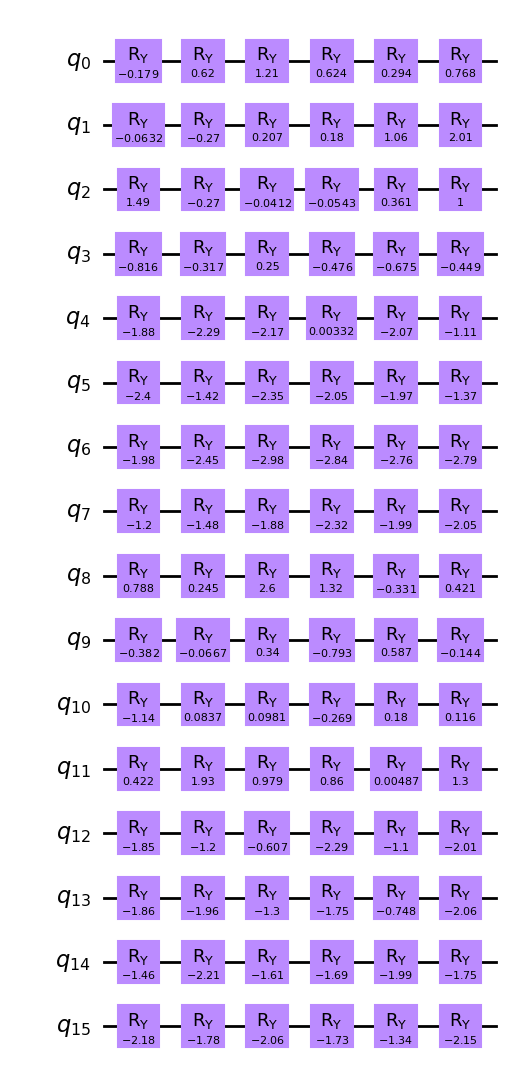

In [62]:
circuit.draw(output='mpl')